# Weakly-supervised end-to-end PCa grading with KQM and attention

In [1]:
!nvidia-smi

Tue Oct 24 13:17:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5500               Off | 00000000:3B:00.0 Off |                  Off |
| 30%   30C    P8              16W / 230W |     14MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import tensorflow as tf
import wandb

from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import numpy as np
from keras import optimizers
from keras import losses
from keras import metrics
from keras.layers import Input, Dense
import keras
import tensorflow_addons as tfa
import os
import pandas as pd
from collections import OrderedDict
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, recall_score, f1_score, accuracy_score, cohen_kappa_score, precision_score
import glob
from sklearn.metrics import pairwise_distances


2023-10-24 13:17:59.897390: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 13:18:01.834633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow co

In [2]:
y1 = [0,
1,
0,
2,
2,
0,
1,
0,
3,
2,
1,
1,
2,
4,
1,
0,
1,
1,
2,
2,
2,
4,
1,
3,
0,
0,
1,
0,
1,
0,
1,
2,
2,
1,
0,
3,
1,
0,
2,
1,
2,
4,
2]

In [3]:
y2 = [2,
1,
0,
0,
1,
0,
1,
0,
3,
2,
1,
1,
2,
3,
1,
1,
1,
1,
2,
0,
1,
3,
1,
1,
0,
0,
1,
1,
1,
0,
1,
1,
2,
1,
0,
3,
1,
0,
2,
1,
1,
2,
1]



In [5]:
consenso = [2,
1,
0,
2,
1,
0,
1,
0,
3,
2,
1,
1,
2,
4,
1,
1,
1,
1,
2,
0,
1,
3,
1,
2,
0,
0,
1,
1,
1,
0,
1,
1,
2,
1,
0,
3,
1,
0,
2,
1,
2,
2,
1]

In [7]:
cohen_kappa_score(y2,consenso, weights='quadratic')

0.9009542612701547

## Data

#### Load Dataframes


In [3]:
mosaic_path = '/root/data/KDM/mosaicsv2'

In [10]:
df_train = pd.read_csv("/root/data/KDM/urkunina_hun_slides/train_0_1234.csv", delimiter=';', header=None)
df_val = pd.read_csv("/root/data/KDM/urkunina_hun_slides/val_0_1234.csv", delimiter=';', header=None)
df_test = pd.read_csv("/root/data/KDM/urkunina_hun_slides/test_0_1234.csv", delimiter=';', header=None)



In [11]:
df_train

,0,1
0,H001,0
1,H003,0
2,H004,0
3,H005,0
4,H008,0
...,...,...
88,U102,1
89,U103,1
90,U104,1
91,U111,1


In [12]:
train_dict = df_train.set_index(0)[1].to_dict(into=OrderedDict)
val_dict = df_val.set_index(0)[1].to_dict(into=OrderedDict)
test_dict = df_test.set_index(0)[1].to_dict(into=OrderedDict)

train_dict = {k: v for k, v in train_dict.items() if os.path.isfile(os.path.join(mosaic_path,f'{k}' + '.png'))}
val_dict = {k: v for k, v in val_dict.items() if os.path.isfile(os.path.join(mosaic_path,f'{k}' + '.png'))}
test_dict = {k: v for k, v in test_dict.items() if os.path.isfile(os.path.join(mosaic_path,f'{k}' + '.png'))}
train_imgs = list(train_dict.keys())

val_imgs = list(val_dict.keys())
test_imgs = list(test_dict.keys())
train_paths = [os.path.join(mosaic_path,str(train_path)+'.png') for train_path in train_imgs]
val_paths = [os.path.join(mosaic_path,str(val_path)+'.png') for val_path in val_imgs]
test_paths = [os.path.join(mosaic_path,str(test_path)+'.png') for test_path in test_imgs]
train_labels = np.array(list(train_dict.values()))
val_labels = np.array(list(val_dict.values()))
test_labels = np.array(list(test_dict.values()))


### Preprocessing

Helper functions to load a sample from storage

In [17]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return img

def process_path(file_path, label):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  #img = tf.cast(img, tf.float32) / 255.0
  return img, label

def process_sample(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = tf.cast(img, tf.float32) / 255.0
  return img


#### One hot encoding of the labels

In [21]:
encoder = OneHotEncoder()
y_train_onehot = encoder.fit_transform(train_labels.reshape(-1,1))
y_train_one_hot = y_train_onehot.toarray()
y_val_onehot = encoder.transform(val_labels.reshape(-1,1))
y_val_one_hot = y_val_onehot.toarray()
y_test_onehot = encoder.transform(test_labels.reshape(-1,1))
y_test_one_hot = y_test_onehot.toarray()

## Datasets

#### Batch size

For A100 largest batch size that fits is 8

In [22]:
batch_size = 4

#### Dataset class that returns a WSI mosaic


In [23]:
def create_dataset(paths,labels,batch_size,shuffle=False):
  num_samples = len(labels)
  paths = tf.data.Dataset.from_tensor_slices(paths)
  labels = tf.data.Dataset.from_tensor_slices(labels)
  ds = tf.data.Dataset.zip((paths,labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=num_samples)
  ds = ds.map(process_path)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds


In [24]:
train_dataset = create_dataset(train_paths, y_train_one_hot, batch_size=4, shuffle=True)
val_dataset = create_dataset(val_paths, y_val_one_hot, shuffle=False, batch_size=4)
test_dataset = create_dataset(test_paths, y_test_one_hot, shuffle=False, batch_size=4)



2023-10-24 13:24:36.549221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22232 MB memory:  -> device: 0, name: NVIDIA RTX A5500, pci bus id: 0000:3b:00.0, compute capability: 8.6
2023-10-24 13:24:36.551010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22232 MB memory:  -> device: 1, name: NVIDIA RTX A5500, pci bus id: 0000:af:00.0, compute capability: 8.6


In [33]:
def get_samples_from_each_class(dataset, n_samples):
    num_classes = 2
    samples_per_class = {class_idx: [] for class_idx in range(num_classes)}
    samples_found_per_class = {class_idx: 0 for class_idx in range(num_classes)}
    samples_collected = 0

    for batch_samples, batch_labels in dataset:
        for sample, label in zip(batch_samples, batch_labels):
            class_idx = np.argmax(label)
            if samples_found_per_class[class_idx] < n_samples:
                samples_per_class[class_idx].append(sample)
                samples_found_per_class[class_idx] += 1
                samples_collected += 1

            if samples_collected == n_samples * num_classes:
                break

        if samples_collected == n_samples * num_classes:
            break

    stacked_samples = tf.stack([sample for samples_list in samples_per_class.values() for sample in samples_list])
    stacked_labels = tf.stack([tf.one_hot(class_idx, depth=num_classes) for class_idx, samples_list in samples_per_class.items() for _ in range(n_samples)])

    return stacked_samples, stacked_labels

In [34]:
with tf.device("/CPU:0"):
  prototypes, prototype_labels = get_samples_from_each_class(train_dataset, 2)

In [35]:
prototypes.shape

TensorShape([4, 1152, 1152, 3])

In [36]:
prototype_labels

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

## KQM

### Patches

In [37]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, image_size, strides):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.strides = strides
        self.num_patches = (image_size - patch_size) // strides + 1

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.strides, self.strides, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches ** 2, patch_dims])
        return patches

### KQM Functions and Kernels

In [38]:
def dm2comp(dm):
    '''
    Extract vectors and weights from a factorized density matrix representation
    Arguments:
     dm: tensor of shape (bs, n, d + 1)
    Returns:
     w: tensor of shape (bs, n)
     v: tensor of shape (bs, n, d)
    '''
    return dm[:, :, 0], dm[:, :, 1:]


def comp2dm(w, v):
    '''
    Construct a factorized density matrix from vectors and weights
    Arguments:
     w: tensor of shape (bs, n)
     v: tensor of shape (bs, n, d)
    Returns:
     dm: tensor of shape (bs, n, d + 1)
    '''
    return tf.concat((w[:, :, tf.newaxis], v), axis=2)

def samples2dm(samples):
    '''
    Construct a factorized density matrix from a batch of samples
    each sample will have the same weight. Samples that are all
    zero will be ignored.
    Arguments:
        samples: tensor of shape (bs, n, d)
    Returns:
        dm: tensor of shape (bs, n, d + 1)
    '''
    w = tf.reduce_any(samples, axis=-1)
    w = w / tf.reduce_sum(w, axis=-1, keepdims=True)
    return comp2dm(w, samples)

def pure2dm(psi):
    '''
    Construct a factorized density matrix to represent a pure state
    Arguments:
     psi: tensor of shape (bs, d)
    Returns:
     dm: tensor of shape (bs, 1, d + 1)
    '''
    ones = tf.ones_like(psi[:, 0:1])
    dm = tf.concat((ones[:,tf.newaxis, :],
                    psi[:,tf.newaxis, :]),
                   axis=2)
    return dm


def dm2discrete(dm):
    '''
    Creates a discrete distribution from the components of a density matrix
    Arguments:
     dm: tensor of shape (bs, n, d + 1)
    Returns:
     prob: vector of probabilities (bs, d)
    '''
    w, v = dm2comp(dm)
    w = w / tf.reduce_sum(w, axis=-1, keepdims=True)
    norms_v = tf.expand_dims(tf.linalg.norm(v, axis=-1), axis=-1)
    v = v / norms_v
    probs = tf.einsum('...j,...ji->...i', w, v ** 2, optimize="optimal")
    return probs


def pure_dm_overlap(x, dm, kernel):
    '''
    Calculates the overlap of a state  \phi(x) with a density
    matrix in a RKHS defined by a kernel
    Arguments:
      x: tensor of shape (bs, d)
     dm: tensor of shape (bs, n, d + 1)
     kernel: kernel function
              k: (bs, d) x (bs, n, d) -> (bs, n)
    Returns:
     overlap: tensor with shape (bs, )
    '''
    w, v = dm2comp(dm)
    overlap = tf.einsum('...i,...i->...', w, kernel(x, v) ** 2)
    return overlap

## Kernels

class CompTransKernelLayer(tf.keras.layers.Layer):
    def __init__(self, transform, kernel):
        '''
        Composes a transformation and a kernel to create a new
        kernel.
        Arguments:
            transform: a function f that transform the input before feeding it to the
                    kernel
                    f:(bs, d) -> (bs, D)
            kernel: a kernel function
                    k:(bs, n, D)x(m, D) -> (bs, n, m)
        '''
        super(CompTransKernelLayer, self).__init__()
        self.transform = transform
        self.kernel = kernel

    def call(self, A, B):
        '''
        Input:
            A: tensor of shape (bs, n, d)
            B: tensor of shape (m, d)
        Result:
            K: tensor of shape (bs, n, m)
        '''
        shape = tf.shape(A) # (bs, n, d)
        A = tf.reshape(A, [shape[0] * shape[1], shape[2]])
        A = self.transform(A)
        dim_out = tf.shape(A)[1]
        A = tf.reshape(A, [shape[0], shape[1], dim_out])
        B = self.transform(B)
        return self.kernel(A, B)

    def log_weight(self):
        return self.kernel.log_weight()

class RBFKernelLayer(tf.keras.layers.Layer):
    def __init__(self, sigma, dim, trainable=True, min_sigma=1e-3):
        '''
        Builds a layer that calculates the rbf kernel between two set of vectors
        Arguments:
            sigma: RBF scale parameter. If it is a tf.Variable it will be used as is.
                     Otherwise it will create a trainable variable with the given value.
        '''
        super(RBFKernelLayer, self).__init__()
        if type(sigma) is tf.Variable:
            self.sigma = sigma
        else:
            self.sigma = tf.Variable(sigma, dtype=tf.float32, trainable=trainable)
        self.dim = dim
        self.min_sigma = min_sigma

    def call(self, A, B):
        '''
        Input:
            A: tensor of shape (bs, n, d)
            B: tensor of shape (m, d)
        Result:
            K: tensor of shape (bs, n, m)
        '''
        shape_A = tf.shape(A)
        shape_B = tf.shape(B)
        A_norm = tf.norm(A, axis=-1)[..., tf.newaxis] ** 2
        B_norm = tf.norm(B, axis=-1)[tf.newaxis, tf.newaxis, :] ** 2
        A_reshaped = tf.reshape(A, [-1, shape_A[2]])
        AB = tf.matmul(A_reshaped, B, transpose_b=True)
        AB = tf.reshape(AB, [shape_A[0], shape_A[1], shape_B[0]])
        dist2 = A_norm + B_norm - 2. * AB
        dist2 = tf.clip_by_value(dist2, 0., np.inf)
        sigma = tf.clip_by_value(self.sigma, self.min_sigma, np.inf)
        K = tf.exp(-dist2 / (2. * sigma ** 2.))
        return K

    def log_weight(self):
        sigma = tf.clip_by_value(self.sigma, self.min_sigma, np.inf)
        return - self.dim * tf.math.log(sigma + 1e-12) - self.dim * np.log(4 * np.pi)



'''
Keras layer version of CosineKernel
'''
class CosineKernelLayer(tf.keras.layers.Layer):
    def __init__(self):
        '''
        Builds a layer that calculates the cosine kernel between two set of vectors
        '''
        super(CosineKernelLayer, self).__init__()
        self.eps = 1e-6

    def call(self, A, B):
        '''
        Input:
            A: tensor of shape (bs, n, d)
            B: tensor of shape (m, d)
        Result:
            K: tensor of shape (bs, n, m)
        '''
        A = tf.math.divide_no_nan(A,
                                  tf.expand_dims(tf.norm(A, axis=-1), axis=-1))
        B = tf.math.divide_no_nan(B,
                                  tf.expand_dims(tf.norm(B, axis=-1), axis=-1))
        K = tf.einsum("...nd,md->...nm", A, B)
        return K

    def log_weight(self):
        return 0


class CrossProductKernelLayer(tf.keras.layers.Layer):

    def __init__(self, dim1, kernel1, kernel2):
        '''
        Create a layer that calculates the cross product kernel of two input
        kernels. The input vector are divided into two parts, the first of dimension
        dim1 and the second of dimension d - dim1. Each input kernel is applied to
        one of the parts of the input.
        Arguments:
            dim1: the dimension of the first part of the input vector
            kernel1: a kernel function
                    k1:(bs, n, dim1)x(m, dim1) -> (bs, n, m)
            kernel2: a kernel function
                    k2:(bs, n, d - dim1)x(m, d - dim1) -> (bs, n, m)
        '''

        super(CrossProductKernelLayer, self).__init__()
        self.dim1 = dim1
        self.kernel1 = kernel1
        self.kernel2 = kernel2

    def call(self, A, B):
        '''
        Input:
            A: tensor of shape (bs, n, d)
            B: tensor of shape (m, d)
        Result:
            K: tensor of shape (bs, n, m)
        '''
        A1 = A[:, :, :self.dim1]
        A2 = A[:, :, self.dim1:]
        B1 = B[:, :self.dim1]
        B2 = B[:, self.dim1:]
        return self.kernel1(A1, B1) * self.kernel2(A2, B2)

    def log_weight(self):
        return self.kernel1.log_weight() + self.kernel2.log_weight()

## Layers and models

def l1_loss(vals):
    '''
    Calculate the l1 loss for a batch of vectors
    Arguments:
        vals: tensor with shape (b_size, n)
    '''
    b_size = tf.cast(tf.shape(vals)[0], dtype=tf.float32)
    vals = vals / tf.norm(vals, axis=1)[:, tf.newaxis]
    loss = tf.reduce_sum(tf.abs(vals)) / b_size
    return loss

class KQMUnit(tf.keras.layers.Layer):
    """Kernel Quantum Measurement Unit
    Receives as input a factored density matrix represented by a set of vectors
    and weight values.
    Returns a resulting factored density matrix.
    Input shape:
        (batch_size, n_comp_in, dim_x + 1)
        where dim_x is the dimension of the input state
        and n_comp_in is the number of components of the input factorization.
        The weights of the input factorization of sample i are [i, :, 0],
        and the vectors are [i, :, 1:dim_x + 1].
    Output shape:
        (batch_size, n_comp, dim_y)
        where dim_y is the dimension of the output state
        and n_comp is the number of components used to represent the train
        density matrix. The weights of the
        output factorization for sample i are [i, :, 0], and the vectors
        are [i, :, 1:dim_y + 1].
    Arguments:
        dim_x: int. the dimension of the input state
        dim_y: int. the dimension of the output state
        x_train: bool. Whether to train or not the x compoments of the train
                       density matrix.
        x_train: bool. Whether to train or not the y compoments of the train
                       density matrix.
        w_train: bool. Whether to train or not the weights of the compoments
                       of the train density matrix.
        n_comp: int. Number of components used to represent
                 the train density matrix
        l1_act: float. Coefficient of the regularization term penalizing the l1
                       norm of the activations.
        l1_x: float. Coefficient of the regularization term penalizing the l1
                       norm of the x components.
        l1_y: float. Coefficient of the regularization term penalizing the l1
                       norm of the y components.
    """
    def __init__(
            self,
            kernel,
            dim_x: int,
            dim_y: int,
            x_train: bool = True,
            y_train: bool = True,
            w_train: bool = True,
            n_comp: int = 0,
            l1_x: float = 0.,
            l1_y: float = 0.,
            l1_act: float = 0.,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.kernel = kernel
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.x_train = x_train
        self.y_train = y_train
        self.w_train = w_train
        self.n_comp = n_comp
        self.l1_x = l1_x
        self.l1_y = l1_y
        self.l1_act = l1_act
        self.c_x = self.add_weight(
            "c_x",
            shape=(self.n_comp, self.dim_x),
            #initializer=tf.keras.initializers.orthogonal(),
            initializer=tf.keras.initializers.random_normal(),
            trainable=self.x_train)
        self.c_y = self.add_weight(
            "c_y",
            shape=(self.n_comp, self.dim_y),
            initializer=tf.keras.initializers.Constant(np.sqrt(1./self.dim_y)),
            #initializer=tf.keras.initializers.random_normal(),
            trainable=self.y_train)
        self.comp_w = self.add_weight(
            "comp_w",
            shape=(self.n_comp,),
            initializer=tf.keras.initializers.constant(1./self.n_comp),
            trainable=self.w_train)
        self.eps = 1e-10

    def call(self, inputs):
        # Weight regularizers
        if self.l1_x != 0:
            self.add_loss(self.l1_x * l1_loss(self.c_x))
        if self.l1_y != 0:
            self.add_loss(self.l1_y * l1_loss(self.c_y))
        #comp_w = tf.clip_by_value(self.comp_w, 1e-10, 1)
        comp_w = tf.abs(self.comp_w) + 1e-6
        # normalize comp_w to sum to 1
        comp_w = comp_w / tf.reduce_sum(comp_w)
        in_w = inputs[:, :, 0]  # shape (b, n_comp_in)
        in_v = inputs[:, :, 1:] # shape (b, n_comp_in, dim_x)
        out_vw = self.kernel(in_v, self.c_x)  # shape (b, n_comp_in, n_comp)
        out_w = (tf.expand_dims(tf.expand_dims(comp_w, axis=0), axis=0) *
                 tf.square(out_vw)) # shape (b, n_comp_in, n_comp)
        out_w = tf.maximum(out_w, self.eps) #########
        # out_w_sum = tf.maximum(tf.reduce_sum(out_w, axis=2), self.eps)  # shape (b, n_comp_in)
        out_w_sum = tf.reduce_sum(out_w, axis=2) # shape (b, n_comp_in)
        out_w = out_w / tf.expand_dims(out_w_sum, axis=2)
        out_w = tf.einsum('...i,...ij->...j', in_w, out_w, optimize="optimal")
                # shape (b, n_comp)
        if self.l1_act != 0:
            self.add_loss(self.l1_act * l1_loss(out_w))
        out_w = tf.expand_dims(out_w, axis=-1) # shape (b, n_comp, 1)
        out_y_shape = tf.shape(out_w) + tf.constant([0, 0, self.dim_y - 1])
        out_y = tf.broadcast_to(tf.expand_dims(self.c_y, axis=0), out_y_shape)
        out = tf.concat((out_w, out_y), 2)
        return out

    def get_config(self):
        config = {
            "dim_x": self.dim_x,
            "dim_y": self.dim_y,
            "n_comp": self.n_comp,
            "x_train": self.x_train,
            "y_train": self.y_train,
            "w_train": self.w_train,
            "l1_x": self.l1_x,
            "l1_y": self.l1_y,
            "l1_act": self.l1_act,
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def compute_output_shape(self, input_shape):
        return (self.dim_y + 1, self.n_comp)

class KQMOverlap(tf.keras.layers.Layer):
    """Kernel Quantum Measurement Overlap Unit
    Receives as input a vector and calculates its overlap with the unit density
    matrix.
    Input shape:
        (batch_size, dim_x)
        where dim_x is the dimension of the input state
    Output shape:
        (batch_size, )
    Arguments:
        kernel: a kernel function
        dim_x: int. the dimension of the input state
        x_train: bool. Whether to train the or not the compoments of the train
                       density matrix.
        w_train: bool. Whether to train the or not the weights of the compoments
                       of the train density matrix.
        n_comp: int. Number of components used to represent
                 the train density matrix
    """

    def __init__(
            self,
            kernel,
            dim_x: int,
            x_train: bool = True,
            w_train: bool = True,
            n_comp: int = 0,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.kernel = kernel
        self.dim_x = dim_x
        self.x_train = x_train
        self.w_train = w_train
        self.n_comp = n_comp
        self.c_x = self.add_weight(
            "c_x",
            shape=(self.n_comp, self.dim_x),
            #initializer=tf.keras.initializers.orthogonal(),
            initializer=tf.keras.initializers.random_normal(),
            trainable=self.x_train)
        self.comp_w = self.add_weight(
            "comp_w",
            shape=(self.n_comp,),
            initializer=tf.keras.initializers.constant(1./self.n_comp),
            trainable=self.w_train)

    def call(self, inputs):
        #comp_w = tf.clip_by_value(self.comp_w, 1e-10, 1)
        comp_w = tf.abs(self.comp_w)
        # normalize comp_w to sum to 1
        comp_w = comp_w / tf.reduce_sum(comp_w)
        in_v = inputs[:, tf.newaxis, :]
        out_vw = self.kernel(in_v, self.c_x) ** 2 # shape (b, 1, n_comp)
        out_w = tf.einsum('...j,...ij->...', comp_w, out_vw, optimize="optimal")
        return out_w

    def get_config(self):
        config = {
            "dim_x": self.dim_x,
            "n_comp": self.n_comp,
            "x_train": self.x_train,
            "w_train": self.w_train,
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def compute_output_shape(self, input_shape):
        return (1,)

class KQMClassModel(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 dim_y,
                 sigma,
                 n_comp,
                 x_train=True):
        super().__init__()
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.n_comp = n_comp
        self.kernel_x = RBFKernelLayer(sigma, dim=dim_x)
        self.kqmu = KQMUnit(self.kernel_x,
                            dim_x=dim_x,
                            dim_y=dim_y,
                            n_comp=n_comp,
                            x_train=x_train)

    def call(self, inputs):
        rho_x = pure2dm(inputs)
        rho_y = self.kqmu(rho_x)
        probs = dm2discrete(rho_y)
        return probs

class BagKQMClassModel(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 dim_y,
                 sigma,
                 n_comp,
                 x_train=True,
                 l1_y=0.):
        super().__init__()
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.n_comp = n_comp
        kernel_x = RBFKernelLayer(sigma)
        self.kqmu = KQMUnit(kernel_x,
                            dim_x=dim_x,
                            dim_y=dim_y,
                            n_comp=n_comp,
                            x_train=x_train,
                            l1_y=l1_y)

    def call(self, inputs):
        in_shape = tf.shape(inputs)
        w = tf.ones_like(inputs[:, :, 0]) / in_shape[1]
        rho_x = comp2dm(w, inputs)
        rho_y = self.kqmu(rho_x)
        probs = dm2discrete(rho_y)
        return rho_y

class KQMDenEstModel(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 sigma,
                 n_comp):
        super().__init__()
        self.dim_x = dim_x
        self.n_comp = n_comp
        self.kernel = RBFKernelLayer(sigma, dim=dim_x)
        self.kqmover = KQMOverlap(self.kernel,
                                dim_x=dim_x,
                                n_comp=n_comp)

    def call(self, inputs):
        log_probs = (tf.math.log(self.kqmover(inputs) + 1e-12)
                     + self.kernel.log_weight())
        self.add_loss(-tf.reduce_mean(log_probs))
        return log_probs


class KQMDenEstModel2(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 dim_y,
                 sigma,
                 n_comp,
                 trainable_sigma=True,
                 min_sigma=1e-3):
        super().__init__()
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.n_comp = n_comp
        self.kernel_x = RBFKernelLayer(sigma, dim=dim_x,
                                       trainable=trainable_sigma,
                                       min_sigma=min_sigma)
        self.kernel_y = CosineKernelLayer()
        self.kernel = CrossProductKernelLayer(dim1=dim_x, kernel1=self.kernel_x, kernel2=self.kernel_y)
        self.kqmover = KQMOverlap(self.kernel,
                                dim_x=dim_x + dim_y,
                                n_comp=n_comp)

    def call(self, inputs):
        log_probs = (tf.math.log(self.kqmover(inputs) + 1e-12)
                     + self.kernel.log_weight())
        self.add_loss(-tf.reduce_mean(log_probs))
        return log_probs

### KQM Attn

In [39]:
class KQMAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,
                 dim_h,
                 dense_units_1,
                 dense_units_2):
        super().__init__()
        self.dim_h = dim_h
        self.dense_units_1 = dense_units_1
        self.dense_units_2 = dense_units_2
        self.mlp_1 = tf.keras.Sequential([
                Dense(dense_units_1, activation='relu'),
                Dense(dim_h, activation='linear')])
        self.mlp_2 = tf.keras.Sequential([
                Dense(dense_units_2, activation='relu'),
                Dense(1, activation='linear')])
    def call(self, input):
        z_local = self.mlp_1(input)
        z_global = tf.reduce_mean(z_local, axis=1)
        z_global = tf.expand_dims(z_global, axis=1)

        z_global = tf.broadcast_to(z_global, tf.shape(z_local))
        z = tf.concat([z_local, z_global], axis=-1)
        z = self.mlp_2(z)
        z = tf.squeeze(z, axis=-1) # eliminate the last dimension which should be 1
        w = tf.nn.softmax(z)
        return w


class KQMSigmoidAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,
                 dim_h,
                 dense_units_1,
                 dense_units_2):
        super().__init__()
        self.dim_h = dim_h
        self.dense_units_1 = dense_units_1
        self.dense_units_2 = dense_units_2
        self.mlp_1 = tf.keras.Sequential([
                Dense(dense_units_1, activation='relu'),
                Dense(dim_h, activation='linear')])
        self.mlp_2 = tf.keras.Sequential([
                Dense(dense_units_2, activation='relu'),
                Dense(1, activation='linear')])

    def call(self, input):
        z_local = self.mlp_1(input)
        z_global = tf.reduce_mean(z_local, axis=1)
        z_global = tf.expand_dims(z_global, axis=1)

        z_global = tf.broadcast_to(z_global, tf.shape(z_local))
        z = tf.concat([z_local, z_global], axis=-1)
        z = self.mlp_2(z)
        z = tf.squeeze(z, axis=-1)

        w = tf.nn.sigmoid(z) # Apply sigmoid to make weights independent
        w = w / tf.reduce_sum(w, axis=-1, keepdims=True) # Normalize the weights so they sum up to 1
        return w

class KQMPatchClassModel(tf.keras.Model):
    def __init__(self,
                 patch_size,
                 image_size,
                 strides,
                 encoder,
                 encoded_size,
                 dim_y,
                 n_comp,
                 sigma=0.1,
                 attention=False,
                 attention_dim_h=64,
                 attention_dense_units_1=64,
                 attention_dense_units_2=64):
        super().__init__()
        self.patch_size = patch_size
        self.image_size = image_size
        self.strides = strides
        self.patch_layer = Patches(patch_size, image_size, strides)
        self.dim_y = dim_y
        self.encoded_size = encoded_size
        self.encoder = encoder
        self.n_comp = n_comp
        self.attention = attention
        self.kernel = RBFKernelLayer(sigma=sigma,
                                         dim=encoded_size,
                                         trainable=True)
        self.kqm_unit = KQMUnit(kernel=self.kernel,
                                       dim_x=encoded_size,
                                       dim_y=dim_y,
                                       n_comp=n_comp)
        if attention:
            self.attention_layer = KQMAttentionLayer(dim_h=attention_dim_h,
                                              dense_units_1=attention_dense_units_1,
                                              dense_units_2=attention_dense_units_2)
    def call(self, input): # (bs, 1152,1152,3)
        patches = self.patch_layer(input) #(bs, n_patches, w*h*c)
        encoded = self.encoder(patches) #()
        bs = tf.shape(encoded)[0]
        if self.attention:
            w = self.attention_layer(encoded)
        else:
            w = tf.ones((bs, self.patch_layer.num_patches ** 2,)) / (self.patch_layer.num_patches ** 2)
        rho_x = comp2dm(w, encoded)
        rho_y = self.kqm_unit(rho_x)
        probs = dm2discrete(rho_y)
        return probs

    def init_components(self, samples_x, samples_y, init_sigma=False, sigma_mult=1):
        patches = self.patch_layer(samples_x)
        idx = tf.random.uniform(shape=(patches.shape[0],), maxval=patches.shape[1], dtype=tf.int32) #select 1 random patch from each mosaic
        # Select the desired patches using tf.gather
        selected_patches = tf.gather(patches, idx, axis=1, batch_dims=1)
        # Encode the selected patches
        encoded_x = self.encoder(selected_patches[:, tf.newaxis, :])[:, 0, :]
        if init_sigma:
            distances = pairwise_distances(encoded_x)
            sigma = np.mean(distances) * sigma_mult
            self.kernel.sigma.assign(sigma)
        self.kqm_unit.c_x.assign(encoded_x)
        self.kqm_unit.c_y.assign(samples_y)
        self.kqm_unit.comp_w.assign(tf.ones((self.n_comp,)) / self.n_comp)

    def visualize_attention(self, input):
        patches = self.patch_layer(input)
        encoded = self.encoder(patches)
        w = self.attention_layer(encoded)
        conv2dt = tf.keras.layers.Conv2DTranspose(filters=1,
            kernel_size=self.patch_layer.patch_size,
            strides=self.patch_layer.strides,
            kernel_initializer=tf.keras.initializers.Ones(),
            bias_initializer=tf.keras.initializers.Zeros(),
            trainable=False)
        w = tf.reshape(w, [-1,
            self.patch_layer.num_patches,
            self.patch_layer.num_patches, 1])
        out = conv2dt(w)
        return out

class KQMSigmoidAttnPatchClassModel(tf.keras.Model):
    def __init__(self,
                 patch_size,
                 image_size,
                 strides,
                 encoder,
                 encoded_size,
                 dim_y,
                 n_comp,
                 sigma=0.1,
                 attention=False,
                 attention_dim_h=64,
                 attention_dense_units_1=64,
                 attention_dense_units_2=64):
        super().__init__()
        self.patch_size = patch_size
        self.image_size = image_size
        self.strides = strides
        self.patch_layer = Patches(patch_size, image_size, strides)
        self.dim_y = dim_y
        self.encoded_size = encoded_size
        self.encoder = encoder
        self.n_comp = n_comp
        self.attention = attention
        self.kernel = RBFKernelLayer(sigma=sigma,
                                         dim=encoded_size,
                                         trainable=True)
        self.kqm_unit = KQMUnit(kernel=self.kernel,
                                       dim_x=encoded_size,
                                       dim_y=dim_y,
                                       n_comp=n_comp)
        if attention:
            self.attention_layer = KQMSigmoidAttentionLayer(dim_h=attention_dim_h,
                                              dense_units_1=attention_dense_units_1,
                                              dense_units_2=attention_dense_units_2)
    def call(self, input): # (bs, 1152,1152,3)
        patches = self.patch_layer(input) #(bs, n_patches, w*h*c)
        encoded = self.encoder(patches) #()
        bs = tf.shape(encoded)[0]
        if self.attention:
            w = self.attention_layer(encoded)
        else:
            w = tf.ones((bs, self.patch_layer.num_patches ** 2,)) / (self.patch_layer.num_patches ** 2)
        rho_x = comp2dm(w, encoded)
        rho_y = self.kqm_unit(rho_x)
        probs = dm2discrete(rho_y)
        return probs

    def init_components(self, samples_x, samples_y, init_sigma=False, sigma_mult=1):
        patches = self.patch_layer(samples_x)
        idx = tf.random.uniform(shape=(patches.shape[0],), maxval=patches.shape[1], dtype=tf.int32) #select 1 random patch from each mosaic
        # Select the desired patches using tf.gather
        selected_patches = tf.gather(patches, idx, axis=1, batch_dims=1)
        # Encode the selected patches
        encoded_x = self.encoder(selected_patches[:, tf.newaxis, :])[:, 0, :]
        if init_sigma:
            distances = pairwise_distances(encoded_x)
            sigma = np.mean(distances) * sigma_mult
            self.kernel.sigma.assign(sigma)
        self.kqm_unit.c_x.assign(encoded_x)
        self.kqm_unit.c_y.assign(samples_y)
        self.kqm_unit.comp_w.assign(tf.ones((self.n_comp,)) / self.n_comp)

    def visualize_attention(self, input):
        patches = self.patch_layer(input)
        encoded = self.encoder(patches)
        w = self.attention_layer(encoded)
        conv2dt = tf.keras.layers.Conv2DTranspose(filters=1,
            kernel_size=self.patch_layer.patch_size,
            strides=self.patch_layer.strides,
            kernel_initializer=tf.keras.initializers.Ones(),
            bias_initializer=tf.keras.initializers.Zeros(),
            trainable=False)
        w = tf.reshape(w, [-1,
            self.patch_layer.num_patches,
            self.patch_layer.num_patches, 1])
        out = conv2dt(w)
        return out

## Training

#### Creating encoder and encoder classifier for warmup

In [40]:
encoded_size = 128

### Encoder that lets weights be loaded into it

In [41]:
def create_convnext_encoder(encoded_size):
  convnext = tf.keras.applications.convnext.ConvNeXtTiny(
    model_name='convnext_tiny',
    include_top=False,
    include_preprocessing=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(192,192,3),
    pooling="avg",
    classes=2,
    classifier_activation='softmax'
  )
  encoder = keras.Sequential([
      Input(shape=(192, 192, 3)),
      convnext,
      keras.layers.Dropout(0.2),
      keras.layers.Dense(encoded_size, activation="relu"), #relu, linear
  ])

  return encoder

### Encoder with reshapes and loaded weights

In [42]:
class Encoder(keras.Model):

  def __init__(self, encoder):
    super().__init__()
    self.encoded_size = encoded_size
    self.encoder = encoder

  def call(self, input): #(bs, n_patches, w*h*c)
    bs = tf.shape(input)[0] # bs
    input = tf.reshape(input,[-1,192,192,3]) # (bs * n_patches, w,h,c)
    x = self.encoder(input) #(bs * num_patches, encoded_size)
    out = tf.reshape(x, [bs, -1, self.encoded_size]) # (bs, num_patches, encoded_size)
    return out

### Instantiate the encoder that will go inside KQM and load pretrained weights to it

In [43]:
convnext = create_convnext_encoder(encoded_size)
encoder_kqm = Encoder(convnext)
convnext.load_weights('/root/data/KDM/models/best_kqm_patch_convnext_extractor.h5')

In [44]:
encoder_cls = keras.Sequential([convnext, keras.layers.Dense(2, activation="softmax")])

In [45]:
def mosaic_to_patch(mosaic, label):

  return mosaic[0:192,0:192,:], label

In [46]:
warmup_dataset = train_dataset.unbatch().map(mosaic_to_patch).batch(256)

In [47]:
encoder_cls.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                loss=losses.categorical_crossentropy,
                metrics=[metrics.categorical_accuracy])

In [48]:
history = encoder_cls.fit(warmup_dataset, epochs=5, verbose=1)

Epoch 1/5


2023-10-24 13:28:29.172735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-24 13:28:31.840372: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff39f0fe150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-24 13:28:31.840398: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5500, Compute Capability 8.6
2023-10-24 13:28:31.840404: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5500, Compute Capability 8.6
2023-10-24 13:28:33.634733: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-10-24 13:28:33.687891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-24 13:28:36.267357: I tensor

1/1 [==============================] - 43s 43s/step - loss: 5.9458 - categorical_accuracy: 0.3333
Epoch 2/5
1/1 [==============================] - 1s 555ms/step - loss: 1.2734 - categorical_accuracy: 0.3974
Epoch 3/5
1/1 [==============================] - 1s 541ms/step - loss: 1.4703 - categorical_accuracy: 0.6410
Epoch 4/5
1/1 [==============================] - 1s 574ms/step - loss: 0.6553 - categorical_accuracy: 0.6282
Epoch 5/5
1/1 [==============================] - 1s 562ms/step - loss: 0.7153 - categorical_accuracy: 0.4872


In [49]:
np.argmax(encoder_cls.predict(warmup_dataset), axis=1)

1/1 [==============================] - 3s 3s/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Train the end-to-end model

#### Callbacks

In [50]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "/root/data/KDM/checkpoints/KDM_weak_upervision_GI.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "min",
    save_freq="epoch",
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 6,
    verbose = 1,
    restore_best_weights=True,
    mode = "min",
)

#### Compiling the model

In [51]:
n_comp = 4
for layer in encoder_kqm.layers:
  layer.trainable = True

In [52]:
kqm_class = KQMPatchClassModel(
                                patch_size=192,
                                image_size=1152,
                                strides=192,
                                encoded_size=encoded_size,
                                dim_y=2,
                                encoder=encoder_kqm,
                                n_comp=n_comp,
                                sigma=1,
                                attention=True,
                                attention_dim_h=64,
                                attention_dense_units_1=128,
                                attention_dense_units_2=128)

kqm_class.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                      loss=losses.CategoricalCrossentropy(),
                      metrics=[metrics.CategoricalAccuracy()])

#### Init components into the model

In [53]:
kqm_class.init_components(prototypes, prototype_labels, init_sigma = True, sigma_mult = 1.)
print(kqm_class.kernel.sigma.numpy())

2.1875606


### Training

In [54]:
next(iter(val_dataset))

(<tf.Tensor: shape=(4, 1152, 1152, 3), dtype=uint8, numpy=
 array([[[[253, 255, 252],
          [255, 255, 253],
          [255, 255, 253],
          ...,
          [254, 240, 253],
          [253, 229, 251],
          [251, 209, 243]],
 
         [[255, 255, 252],
          [255, 255, 254],
          [255, 255, 255],
          ...,
          [254, 249, 253],
          [253, 246, 253],
          [251, 242, 253]],
 
         [[255, 255, 253],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [250, 228, 241],
          [247, 226, 242],
          [249, 219, 241]],
 
         ...,
 
         [[210, 156, 221],
          [226, 159, 227],
          [236, 165, 229],
          ...,
          [252, 214, 243],
          [252, 234, 245],
          [253, 244, 251]],
 
         [[228, 168, 234],
          [236, 169, 230],
          [239, 166, 227],
          ...,
          [246, 200, 242],
          [245, 212, 239],
          [245, 217, 244]],
 
         [[236, 175, 238]

In [55]:
history = kqm_class.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1, callbacks=[checkpoint_callback, earlystop])

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.7685 - categorical_accuracy: 0.6154
Epoch 1: val_loss improved from inf to 0.58249, saving model to /root/data/KDM/checkpoints/KDM_weak_upervision_GI.h5
20/20 [==============================] - 65s 1s/step - loss: 0.7685 - categorical_accuracy: 0.6154 - val_loss: 0.5825 - val_categorical_accuracy: 0.7143
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.6150 - categorical_accuracy: 0.6667
Epoch 2: val_loss did not improve from 0.58249
20/20 [==============================] - 15s 752ms/step - loss: 0.6150 - categorical_accuracy: 0.6667 - val_loss: 0.6485 - val_categorical_accuracy: 0.7143
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.6427 - categorical_accuracy: 0.6538
Epoch 3: val_loss did not improve from 0.58249
20/20 [==============================] - 15s 754ms/step - loss: 0.6427 - categorical_accuracy: 0.6538 - val_loss: 0.6650 - val_categorical_accuracy: 0.7857
Epoch 

In [41]:
unfhuffled_train_ds = create_dataset(train_paths, y_train_one_hot, shuffle=False, batch_size=4)


In [42]:
out = np.argmax(kqm_class.predict(unfhuffled_train_ds), axis =1)

7/7 [==============================] - 2s 213ms/step


In [43]:
out

array([0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0,
       0, 0, 0, 0, 2, 2])

In [ ]:
y_true = np.argmax(np.concatenate([y for x,y in unfhuffled_train_ds], axis=0), axis = 1)

In [46]:
y_true

array([0, 2, 0, 2, 0, 0, 0, 3, 0, 0, 0, 1, 0, 3, 1, 1, 0, 0, 0, 1, 2, 0,
       0, 0, 0, 0, 2, 2])

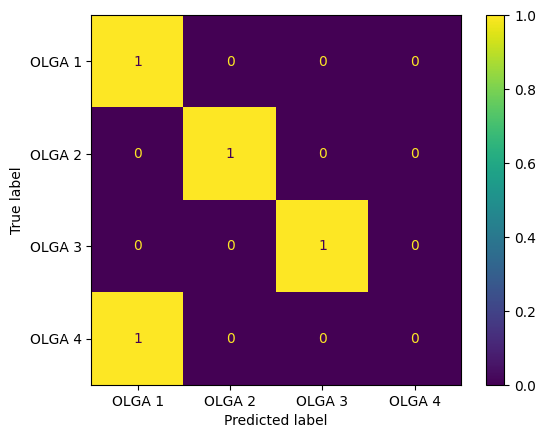

In [45]:
ConfusionMatrixDisplay.from_predictions(y_true, out, normalize='true', display_labels=['OLGA 1', 'OLGA 2', 'OLGA 3', 'OLGA 4'])

In [32]:
kqm_class(next(iter(train_dataset))[0])
kqm_class.load_weights("/content/drive/MyDrive/data/kqm_data/attn_kqm_cls_from_kqm_patch_cls_unfrozen.h5")
kqm_class.evaluate(test_dataset)


354/354 [==============================] - 151s 411ms/step - loss: 0.8675 - categorical_accuracy: 0.6627 - cohen_kappa: 0.8975


[0.8675325512886047, 0.6626591086387634, 0.89754319190979]

348/348 [==============================] - 134s 385ms/step


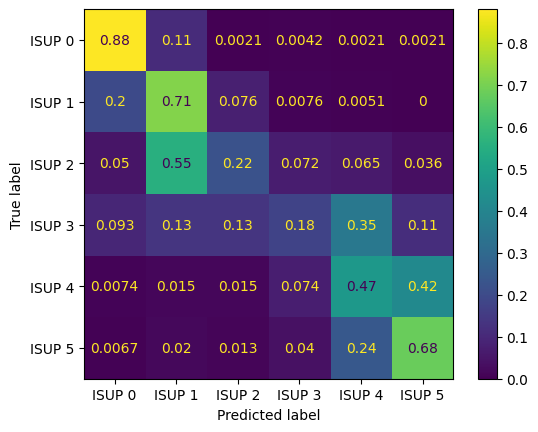

In [39]:
preds = kqm_class.predict(val_dataset)
predictions = np.argmax(preds, axis =1)
y_true = np.argmax(np.concatenate([y for x,y in val_dataset], axis=0), axis = 1)
ConfusionMatrixDisplay.from_predictions(y_true, predictions, normalize='true', display_labels=['ISUP 0', 'ISUP 1', 'ISUP 2', 'ISUP 3', 'ISUP 4', 'ISUP 5'])

In [40]:
cohen_kappa_score(y_true, predictions, weights='quadratic')


0.8903542850069945

In [41]:
mean_absolute_error(y_true / 5., predictions / 5.)


0.08589928057553957

In [42]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       473
           1       0.66      0.71      0.69       396
           2       0.39      0.22      0.28       139
           3       0.35      0.18      0.23        97
           4       0.44      0.47      0.45       136
           5       0.58      0.68      0.62       149

    accuracy                           0.66      1390
   macro avg       0.54      0.52      0.52      1390
weighted avg       0.63      0.66      0.64      1390



In [ ]:
# ConfusionMatrixDisplay.from_predictions(y_true, predictions, normalize='true', display_labels=['ISUP 0', 'ISUP 1', 'ISUP 2', 'ISUP 3', 'ISUP 4', 'ISUP 5'])

In [ ]:
wandb.finish()

epoch/categorical_accuracy,▁▂▃▄▅▅▆▇▆▇▇▇█▇███
epoch/cohen_kappa,▁▄▅▆▆▇▇█▇▇███████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▂▃▂▂▂▁▂▁▁▁
epoch/val_categorical_accuracy,▄▇▃▇▇█▆▆▆▆▆▃▆▅▁▅▂
epoch/val_cohen_kappa,▄▇▇▇███▇▅▇█▇██▁▇▅
epoch/val_loss,▃▂▂▁▁▁▁▂▄▂▂▄▃▃█▄▅
epoch/categorical_accuracy,0.92395
epoch/cohen_kappa,0.97209
epoch/epoch,16


In [ ]:
from google.colab import runtime
runtime.unassign()